<a href="https://colab.research.google.com/github/pixiedust18/DeCloud-GAN/blob/main/DeCloudGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# installing tensorflow 2.1
!pip install --quiet tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8 MB 5.7 kB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.8 MB 55.8 MB/s 
     |████████████████████████████████| 448 kB 50.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires gast==0.4.0, but you have gast 0.2.2 which is incompatible.
tensorflow 2.6.0 requires tensorboard~=2.6, but you have tensorboard 2.1.1 which is incompatible.
tensorflow 2.6.0 requires tensorflow-estimator~=2.6, but you have tensorflow-estimator 2.1.0 which is incompatible.
tensorflow-probability 0.14.1 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [ ]:
import os                       # pkg to read filepaths from the dataset folder
import tensorflow as tf         # tensorflow
import tensorflow.keras as K    # keras API
import numpy as np              # numpy to work with tensors (with tf)
import matplotlib.pyplot as plt # function to show images
%matplotlib inline              
import cv2                      # pkg to load image as np.array

# vgg net for perceptual loss
from tensorflow.keras.applications.vgg19 import VGG19

# Define Losses

In [ ]:
input_size = 256 # 128x128x3 images (training_set)
batch_size= 8

In [ ]:
# Perceptual loss function 

# load pre-trained (imagenet) vgg network, excluding fully-connected layer on the top
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = K.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
# make the net not trainable
for l in vgg_layer.layers: l.trainable=False 

print(vgg_layer.summary())

def perceptual_loss(y_true,y_pred):
    '''This function computes the perceptual loss using an already trained VGG layer'''
    y_t=vgg_layer(y_true)
    y_p=vgg_layer(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

80142336/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
# defining other metrics:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

# Data processing

In [ ]:
!mkdir '/content/rice/'

!unzip "/content/gdrive/MyDrive/RICE_DATASET.zip" -d "/content/rice/"

Archive:  /content/gdrive/MyDrive/RICE_DATASET.zip
   creating: /content/rice/RICE_DATASET/
   creating: /content/rice/RICE_DATASET/RICE1/
   creating: /content/rice/RICE_DATASET/RICE1/cloudy_image/
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/0.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/1.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/10.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/100.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/101.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/102.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/103.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/104.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/105.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/106.png  
  inflating: /content/rice/RICE_DATASET/RICE1/cloudy_image/107.png  
  inflating: /content/rice/RICE_DATASET/RICE1/c

In [ ]:
def read_image(img_path):
    """
    function which loads an image from a path and convert it into np array
    """
    img = cv2.imread(img_path)
    b,g,r = cv2.split(img)   # cv2 reads BGR instead of canonical RGB
    img = cv2.merge([r,g,b]) # Switching it to RGB
    img = cv2.resize(img, (256, 256))
    #cv2_imshow(img)

    return img

## RICE 1 

In [ ]:
def get_file_list(file_list_path):
  file1 = open(file_list_path, 'r')
  trainl = file1.readlines()
  train_target_list = []
  train_crappy_list = []

  path = '/content/rice/RICE_DATASET/RICE1'

  for file in trainl:
    crappy_file = path+'/cloudy_image/'+file.replace('\n', '')
    target_file = path+'/ground_truth/'+file.replace('\n', '')
    #crappy_file = path+'/cloud/'+file.replace('\n', '')
    #target_file = path+'/label/'+file.replace('\n', '')
    train_target_list.append(target_file)
    train_crappy_list.append(crappy_file)
    #print(crappy_file, target_file)
  return train_target_list, train_crappy_list

In [ ]:
train_target_list, train_crappy_list = get_file_list('/content/rice/RICE_DATASET/RICE1/train_list.txt')
test_target_list, test_crappy_list = get_file_list('/content/rice/RICE_DATASET/RICE1/test_list.txt')
print('train:', len(train_target_list), 'test:', len(test_target_list))

train: 400 test: 100


## RICE 2

In [ ]:
def get_file_list(list_path, file_list):
  full_list = []

  for file in file_list:
    #crappy_file = path+'/cloudy_image/'+file.replace('\n', '')
    #target_file = path+'/ground_truth/'+file.replace('\n', '')
    crappy_file = os.path.join(list_path, file)
    full_list.append(crappy_file)
    #print(crappy_file, target_file)
  return full_list

In [ ]:
rice2_crappy_list = os.listdir('/content/rice/RICE_DATASET/RICE2/cloud')
div = int(0.8 * len(rice2_crappy_list))
rice2_crappy_list = get_file_list('/content/rice/RICE_DATASET/RICE2/cloud', rice2_crappy_list)
#train_crappy_list = train_crappy_list+(rice2_crappy_list[0:div])
train_crappy_list = (rice2_crappy_list[0:div])

test_crappy_list = rice2_crappy_list[div:(len(rice2_crappy_list))]
rice2_target_list = os.listdir('/content/rice/RICE_DATASET/RICE2/label')
rice2_target_list = get_file_list('/content/rice/RICE_DATASET/RICE2/label', rice2_target_list)
#train_target_list = train_target_list+(rice2_target_list[0:div])
train_target_list = (rice2_target_list[0:div])

test_target_list = rice2_target_list[div:(len(rice2_crappy_list)-1)]
print('train:', len(train_target_list), 'test:', len(test_target_list))

train: 588 test: 147


In [ ]:
len(train_crappy_list)

588

In [ ]:
def train_generator():
    global batch_size
    while True:
        for start in range(0, len(train_target_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(train_target_list))
                    ids_train_batch_target = train_target_list[start:end]
                    ids_train_batch_crappy = train_crappy_list[start:end]

                    for x, y in zip(ids_train_batch_crappy, ids_train_batch_target):
                        img_y = read_image(y)
                        img_x = read_image(x)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch


def test_generator():
    global batch_size
    while True:
        for start in range(0, len(test_target_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(test_target_list))
                    ids_test_batch_target = test_target_list[start:end]
                    ids_test_batch_crappy = test_crappy_list[start:end]

                    for x, y in zip(ids_test_batch_crappy, ids_test_batch_target):
                        img_y = read_image(y)
                        img_x = read_image(x)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                        break
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch


In [ ]:
def train_dataset():
    global batch_size
    x_batch = []
    y_batch = []
    for x, y in zip(train_crappy_list, train_target_list):
        img_y = read_image(y)
        img_x = read_image(x)
        #img_y.resize((256, 256, 3), refcheck=False)
        #img_x.resize((256, 256, 3), refcheck=False)
        x_batch.append(np.array(img_x,np.float32)/255.)
        y_batch.append(np.array(img_y,np.float32)/255.)
    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)      
    return x_batch,y_batch


def test_dataset():
    global batch_size
    x_batch = []
    y_batch = []
    i=0
    for x, y in zip(test_crappy_list, test_target_list):
        if not (os.path.isfile(x) and os.path.isfile(y)):
          i+=1
          continue
        img_y = read_image(y)
        img_x = read_image(x)
        #img_y.resize((256, 256, 3), refcheck=False)
        #img_x.resize((256, 256, 3), refcheck=False)

        x_batch.append(np.array(img_x,np.float32)/255.)
        y_batch.append(np.array(img_y,np.float32)/255.)  
        i+=1
        #cv2_imshow(img_y)
    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)    
    return x_batch,y_batch


In [ ]:
if not (os.path.isfile('rf') and os.path.isfile(test_crappy_list[31])):
  print('ds')

ds


# UNet Model Architecture

In [ ]:
# pixel shuffle 
def pixel_shuffle(scale):
    '''
    This function implements pixel shuffling.
    ATTENTION: the scale should be bigger than 2, otherwise just returns the input.
    '''
    if scale > 1:
        return lambda x: tf.nn.depth_to_space(x, scale)
    else:
        return lambda x:x

In [ ]:
def add_down_block(x_inp, filters, kernel_size=(3, 3), padding="same", strides=1,r=False):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    if r:
        # if r=True then we import an (1X1) Conv2D after input layer 
        # in order the dimensions of 2 tensors coincide.
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x

def add_up_block(x_inp,skip,filters, kernel_size=(3, 3), padding="same", strides=1,upscale_factor=2):
    x = pixel_shuffle(scale=upscale_factor)(x_inp)
    x = K.layers.Concatenate()([x, skip])
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Activation('relu')(x)
    return x

def add_bottleneck(x_inp,filters, kernel_size=(3, 3), padding="same", strides=1):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.Activation('relu')(x)
    return x

In [ ]:
def RUNet():
    """
      Implementing with Keras the Robust UNet Architecture as proposed by
      Xiaodan Hu, Mohamed A. Naiel, Alexander Wong, Mark Lamm, Paul Fieguth
      in "RUNet: A Robust UNet Architecture for Image Super-Resolution"
    """
    inputs = K.layers.Input((input_size,input_size, 3))
    
    
    down_1 = K.layers.Conv2D(64,(7,7), padding="same", strides=1)(inputs)
    down_1 = K.layers.BatchNormalization()(down_1)
    down_1 = K.layers.Activation('relu')(down_1)
    
    down_2 = K.layers.MaxPool2D(pool_size=(2,2))(down_1)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,128,r=True)
    
    down_3 = K.layers.MaxPool2D(pool_size=(2, 2),strides=2)(down_2)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,256,r=True)
    
    down_4 = K.layers.MaxPool2D(pool_size=(2, 2))(down_3)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,512,r=True) 
    
    down_5 = K.layers.MaxPool2D(pool_size=(2, 2))(down_4)
    down_5 = add_down_block(down_5,512)
    down_5 = add_down_block(down_5,512)
    down_5 = K.layers.BatchNormalization()(down_5)
    down_5 = K.layers.Activation('relu')(down_5)
    
    
    bn_1 = add_bottleneck(down_5, 1024)
    bn_2 = add_bottleneck(bn_1, 512)
    
    up_1 = add_up_block(bn_2,down_5, 512,upscale_factor=1)
    up_2 = add_up_block(up_1,down_4, 384,upscale_factor=2)
    up_3 = add_up_block(up_2,down_3, 256,upscale_factor=2)
    up_4 = add_up_block(up_3,down_2, 96,upscale_factor=2) 
    
    up_5 = pixel_shuffle(scale=2)(up_4)
    up_5 = K.layers.Concatenate()([up_5,down_1])
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)
   
    outputs = K.layers.Conv2D(3,(1,1), padding="same")(up_5)
    model = K.models.Model(inputs, outputs)
    return model

unet_model = RUNet()
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

# UNet Train

In [ ]:
checkpoint_filepath1 = '/content/gdrive/MyDrive/best_ssim/'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='ssim',
    mode='max',
    save_best_only=True)

In [ ]:
checkpoint_filepath2 = '/content/gdrive/MyDrive/best_psnr/'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='psnr',
    mode='max',
    save_best_only=True)

In [ ]:
opt=K.optimizers.Adam(learning_rate=0.0015) # Adam optimizer
unet_model.compile(optimizer=opt,loss=[K.losses.mean_squared_error],metrics=[psnr,ssim,K.losses.mean_squared_error])

In [ ]:
history = unet_model.fit_generator(generator=train_generator(),
                              steps_per_epoch=np.ceil(float(len(train_target_list)) / float(batch_size)),
                              epochs=250,
                              verbose=1,
                              validation_data=test_generator(),
                              shuffle=True,
                              validation_steps=np.ceil(float(len(test_target_list)) / float(batch_size)),
                              callbacks=[model_checkpoint_callback1])

In [ ]:
#model.evaluate(test_generator())

In [ ]:
#model.save_weights('/content/gdrive/MyDrive/unet_sr_best_best')

In [ ]:
unet_model.load_weights('/content/gdrive/MyDrive/unet_sr_best_best')

In [ ]:
#res = unet_model.predict(img_x)

In [ ]:
#res.shape

In [ ]:
#cv2.resize(res, (256, 256))

In [ ]:
#plt.imshow(res)

In [ ]:
from google.colab.patches import cv2_imshow
def unet_custom_test(test_dataset):
  samples = 15
  X_realA, X_realB = test_dataset
  fakes = unet_model.predict(X_realA)
  psnr_tot = 0
  ssim_tot = 0

  for i in range(samples):
    real = tf.convert_to_tensor(X_realB[i])
    fake = tf.convert_to_tensor(fakes[i])

    psnr_score = psnr(real, fake).numpy()
    #print(psnr_score)
    ssim_score = ssim(real, fake).numpy()
    #print(ssim_score)
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(X_realA[i], aspect='auto')
    fig.savefig('/content/cloudy/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(X_realB[i], aspect='auto')
    fig.savefig('/content/target/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    #cv2_imshow(X_realA[i])
    
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(fakes[i], aspect='auto')
    fig.savefig('/content/fake/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    '''plt.figure()
    #fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

    plt.imshow(X_realA[i])
    plt.figure()
    #fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

    plt.imshow(fakes[i])
    #plt.savefig('plot.png', bbox_inches='tight', pad_inches=0)'''

    psnr_tot+=psnr_score
    ssim_tot+=ssim_score
  print("SSIM: ", ssim_tot/samples, " PSNR ", psnr_tot/samples)
  return ssim_tot/samples, psnr_tot/samples

#unet_custom_test(test_dataset())

# Discriminator

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_5[0][0]        

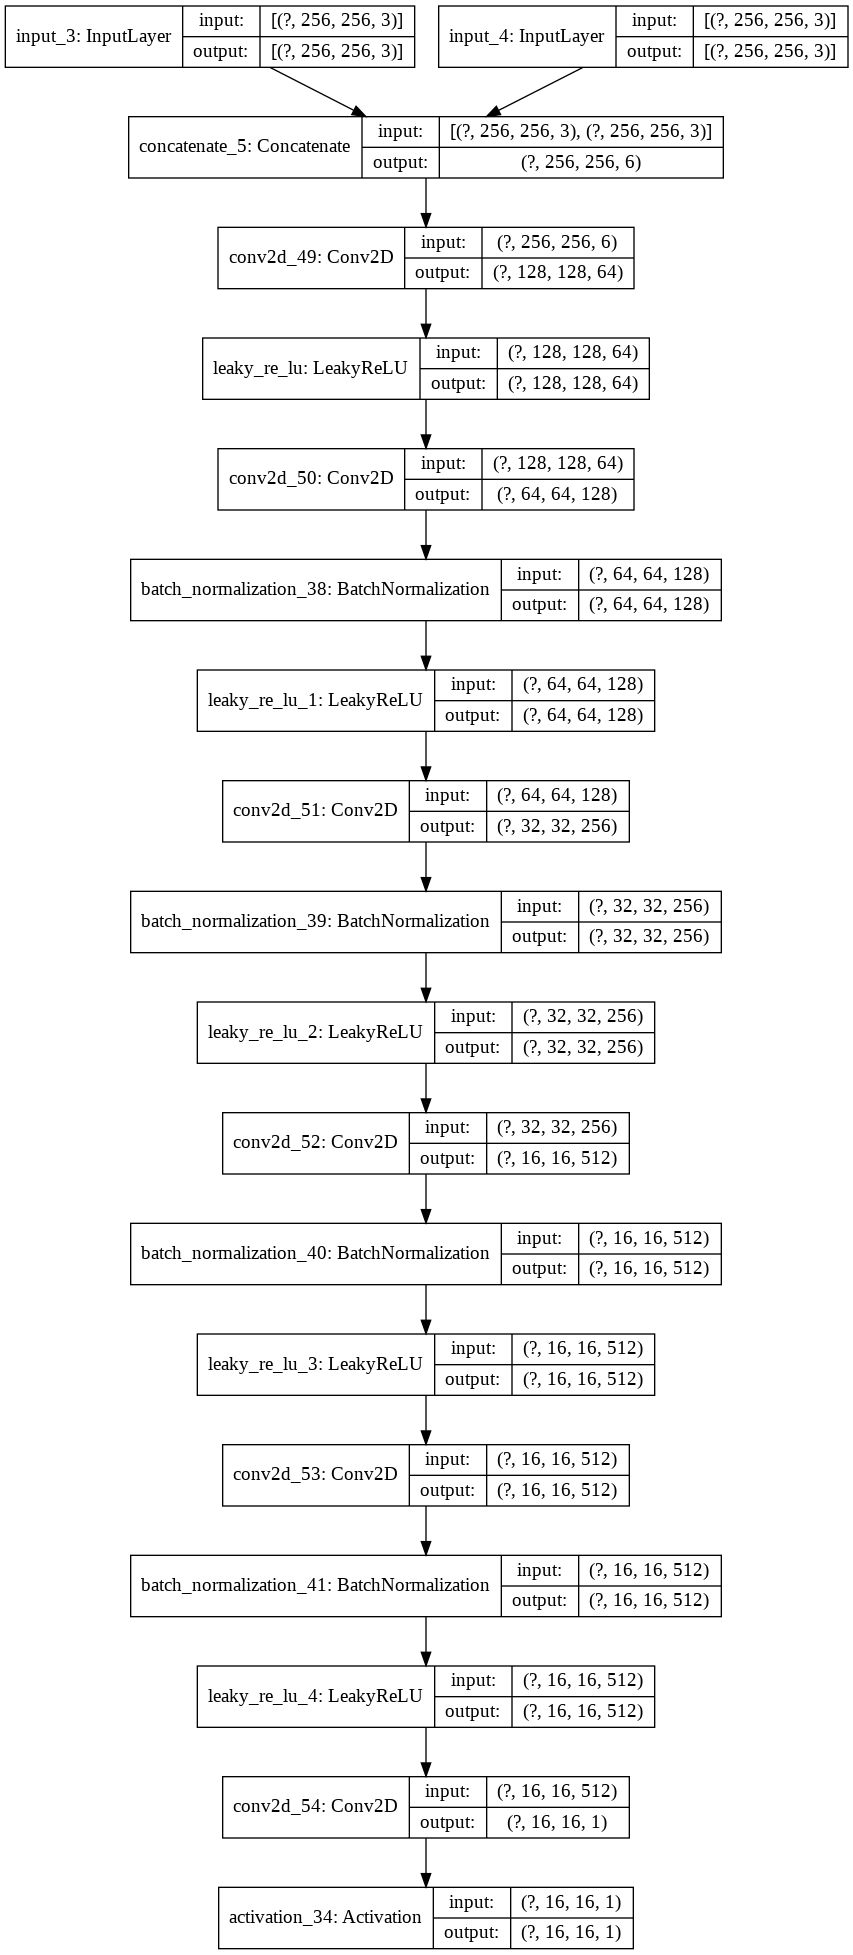

In [ ]:
def define_discriminator(image_shape):
	# weight initialization
	init = K.initializers.RandomNormal(stddev=0.02)
	# source image input
	in_src_image = K.layers.Input(shape=image_shape)
	# target image input
	in_target_image = K.layers.Input(shape=image_shape)
	# concatenate images channel-wise
	merged = K.layers.Concatenate()([in_src_image, in_target_image])
	# C64
	d = K.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = K.layers.LeakyReLU(alpha=0.2)(d)
	# C128
	d = K.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = K.layers.BatchNormalization()(d)
	d = K.layers.LeakyReLU(alpha=0.2)(d)
	# C256
	d = K.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = K.layers.BatchNormalization()(d)
	d = K.layers.LeakyReLU(alpha=0.2)(d)
	# C512
	d = K.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = K.layers.BatchNormalization()(d)
	d = K.layers.LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = K.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = K.layers.BatchNormalization()(d)
	d = K.layers.LeakyReLU(alpha=0.2)(d)
	# patch output
	d = K.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = K.layers.Activation('sigmoid')(d)
	# define model
	model = K.models.Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = K.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model
 
# define image shape
image_shape = (input_size,input_size,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
K.utils.plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

# GAN Defintion

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, K.layers.BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = K.layers.Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = K.models.Model(in_src, [dis_out, gen_out])
	# compile model
	opt = K.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100], metrics=[psnr,ssim,K.losses.mean_squared_error])
	return model

In [ ]:
image_shape = (256,256,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = RUNet()
#g_model.load_weights('/content/gdrive/MyDrive/unet_sr')
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
#K.utils.plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 256, 256, 3)  43192331    input_8[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 16, 16, 1)    6968257     input_8[0][0]                    
                                                                 model_4[1][0]                    
Total params: 50,160,588
Trainable params: 43,174,475
Non-trainable params: 6,986,113
__________________________________________________________________________________________________


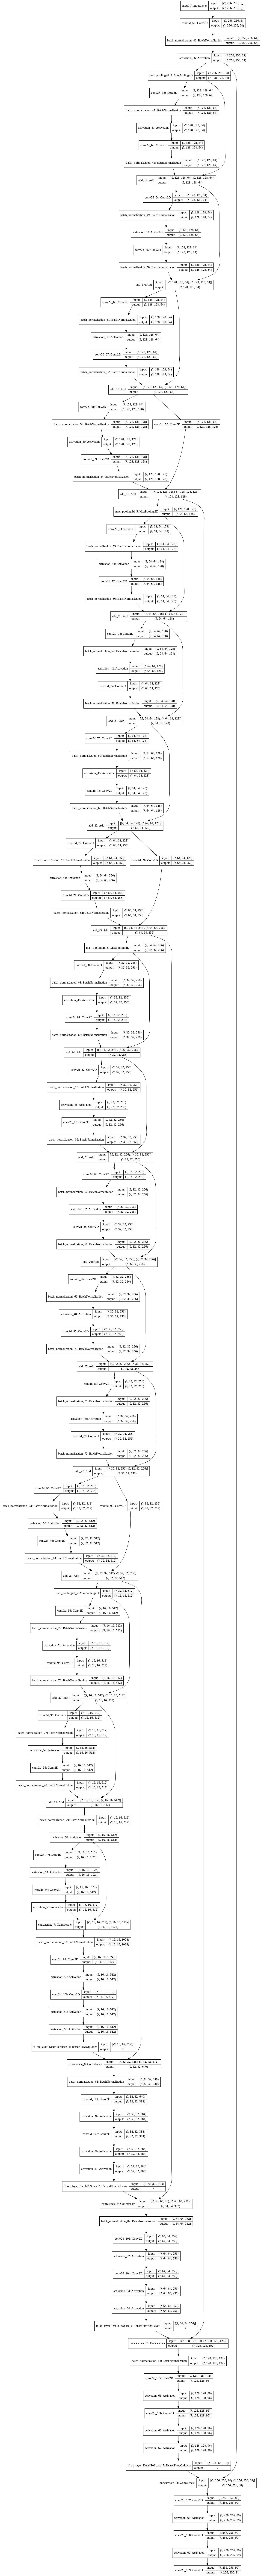

In [ ]:
K.utils.plot_model(g_model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!nvidia-smi

Sat Oct  9 21:46:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    37W / 250W |   6689MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Aiding functions

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
import math
def psnr_np(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

In [ ]:
def ssim_np(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [ ]:
def custom_test(test_dataset):
  [X_realA, X_realB], y_real = generate_real_samples(test_dataset(), 100, 16)
  fakes = g_model.predict(X_realA)
  psnr_tot = 0
  ssim_tot = 0

  for i in range(100):
    real = tf.convert_to_tensor(X_realB[i])
    fake = tf.convert_to_tensor(fakes[i])
    psnr_score = psnr(real, fake).numpy()
    #print(psnr_score)
    ssim_score = ssim(real, fake).numpy()
    #print(ssim_score)
    #plt.imshow(X_realB[i])
    #plt.imshow(fakes[i])
    psnr_tot+=psnr_score
    ssim_tot+=ssim_score
  print("SSIM: ", ssim_tot/100, " PSNR ", psnr_tot/100)

custom_test(test_dataset)

SSIM:  0.029047994567081334  PSNR  10.898663992881774


In [ ]:
def generate_fake_samples(g_model, samples, targets, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	#plt.imshow(X[0])
	#print("PSNR: ", psnr_np(samples, X))
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# Train GAN

In [ ]:
max_psnr_g = 30
max_ssim_g = 0.8

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, test_dataset, max_psnr = 25, max_ssim = 0.86, n_epochs=200, n_batch=8, n_patch=16):
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = 24
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	psnr_tot = 0
	msee_tot = 0
	ssim_tot = 0
	psnr_tot_2 = 0
	msee_tot_2 = 0
	ssim_tot_2 = 0
	trloss = 0
	teloss=0
	at=0
	bt=0
	ct=0
	dt=0
	n_steps = int(trainA.shape[0]//n_batch)
	print(trainA.shape[0], n_steps)
	# manually enumerate epochs
	
	for i in range(n_epochs):
		psnr_tot = 0
		msee_tot = 0
		ssim_tot = 0
		psnr_tot_2 = 0
		msee_tot_2 = 0
		ssim_tot_2 = 0
		q1_tot = 0
		q2_tot = 0
		q3_tot = 0
		q1_tot_2 = 0
		q2_tot_2 = 0
		q3_tot_2 = 0
		trloss = 0
		teloss=0
		print("Epoch: ", i+1)

		for j in range((n_steps)):
		# select a batch of real samples
			[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
			#X_realA.resize((1, 256, 256, 3), refcheck=False)
			#X_realB.resize((1, 256, 256, 3), refcheck=False)
			#print(y_real.shape)
			#y_real.resize((1, 256, 256, 3))

			# generate a batch of fake samples
			X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, X_realB, n_patch)
			#cv2_imshow(X_fakeB)
			#break
			#print(y_fake.shape)
			# update discriminator for real samples
			d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
			# update discriminator for generated samples
			d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
			# update the generator
			#g_loss, psnr, ssim, msee, xd, ab, bc, cd, de = gan_model.train_on_batch(X_realA, [y_real, X_realB])
			g_loss, _, _, q1, q2, q3, psnr, ssim, msee,  = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	 
			[X_realA_test, X_realB_test], y_real_test = generate_real_samples(test_dataset, n_batch, n_patch)
			g_loss_2, _, _,q1_2, q2_2, q3_2, psnr_2, ssim_2, msee_2  = gan_model.test_on_batch(X_realA_test, [y_real_test, X_realB_test])
			#tr = gan_model.train_on_batch(X_realA, [y_real, X_realB])
			#te = gan_model.test_on_batch(X_realA, [y_real, X_realB])
			psnr_tot+=psnr
			msee_tot+=msee
			ssim_tot+=ssim
			psnr_tot_2+=psnr_2
			msee_tot_2+=msee_2
			ssim_tot_2+=ssim_2
			trloss+=g_loss
			teloss+=g_loss_2
			q1_tot+=q1
			q2_tot+=q2
			q3_tot+=q3
			q1_tot_2+=q1_2
			q2_tot_2+=q2_2
			q3_tot_2+=q3_2
			print('\t >%d, d1[%.3f] d2[%.3f] g[%.3f]' % (j+1, d_loss1, d_loss2, g_loss))

		print("\n\t\tTrain\n\tLoss: ", trloss, "PSNR: ", psnr_tot/n_steps, "SSIM: ", ssim_tot/n_steps, "MSE: ", msee_tot/n_steps, f' q1: {q1_tot/n_steps}, q2:{q2_tot/n_steps}, q3:{q3_tot/n_steps}\n')
		print("\t\tTest\n\tLoss: ", teloss, "PSNR: ", psnr_tot_2/n_steps, "SSIM: ", ssim_tot_2/n_steps, "MSE: ", msee_tot_2/n_steps, f' q1: {q1_tot_2/n_steps}, q2:{q2_tot_2/n_steps}, q3:{q3_tot_2/n_steps}\n')
		ssim_tot_2, psnr_tot_2 = custom_test(test_dataset)
	
		if (psnr_tot_2 > max_psnr):
			gan_model.save_weights('/content/gdrive/MyDrive/gan_model/max_ssim_rice2_t2/')
			max_psnr = psnr_tot_2
			print("\n ------------\nSaved psnr model \n------------------")
			
		if (ssim_tot_2 > max_ssim):
			gan_model.save_weights('/content/gdrive/MyDrive/gan_model/max_psnr_rice2_t2/')
			max_ssim = ssim_tot_2
			print("\n ------------\nSaved ssim model \n------------------")
		#psnr_tot+=psnr
		#msee_tot+=msee
		#ssim_tot+=ssim
		#at+=a
		#bt+=b
		#ct+=c
		#dt+=d
		# summarize performance
		#print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		#print("Epoch: ", i+1)
		#print("\tTrain\n\t", tr)
		#print("\tTest\n\t", te)
	#print("PSNR: ", psnr_tot/n_steps, "MSEE: ", ssim_tot/n_steps, "SSIM: ", msee_tot/n_steps, "\n")
	return max_psnr, max_ssim

In [ ]:
max_psnr_g, max_ssim_g = train(d_model, g_model, gan_model, train_dataset(), test_dataset(), max_psnr_g, max_ssim_g)

In [ ]:
print(max_psnr_g, max_ssim_g)

In [ ]:
print(max_psnr_g, ' ' ,max_ssim_g)

In [ ]:
gan_model.save_weights('/content/gdrive/MyDrive/gan_model/x')

In [ ]:
gan_model.load_weights('/content/gdrive/MyDrive/gan_model/rice1_wts/')

In [ ]:
train(d_model, g_model, gan_model, train_dataset())

# Test

In [ ]:
from google.colab.patches import cv2_imshow
def custom_test(test_dataset):
  samples = 14
  X_realA, X_realB = test_dataset
  fakes = g_model.predict(X_realA)
  psnr_tot = 0
  ssim_tot = 0

  for i in range(samples):
    real = tf.convert_to_tensor(X_realB[i])
    fake = tf.convert_to_tensor(fakes[i])
    psnr_score = psnr(real, fake).numpy()
    #print(psnr_score)
    ssim_score = ssim(real, fake).numpy()
    #print(ssim_score)
    '''fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(X_realA[i], aspect='auto')
    fig.savefig('/content/cloudy/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(X_realB[i], aspect='auto')
    fig.savefig('/content/target/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    #cv2_imshow(X_realA[i])
    
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(fakes[i], aspect='auto')
    fig.savefig('/content/fake/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)'''
    '''plt.figure()
    #fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

    plt.imshow(X_realA[i])
    #plt.savefig('plot.png', bbox_inches='tight', pad_inches=0)'''

    psnr_tot+=psnr_score
    ssim_tot+=ssim_score
  print("SSIM: ", ssim_tot/samples, " PSNR ", psnr_tot/samples)
  return ssim_tot/samples, psnr_tot/samples

custom_test(test_dataset())

In [ ]:
generate_fake_samples(g_model, img_X, X_realB, n_patch)

In [ ]:
X = g_model.predict(img_x)

In [ ]:
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, X_realB, n_patch)